In [1]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)

2025-05-06 15:37:27,002 [INFO] WRITING LOG OUTPUT TO /Users/demir/.cellpose/run.log
2025-05-06 15:37:27,002 [INFO] 
cellpose version: 	3.1.1.1 
platform:       	darwin 
python version: 	3.10.17 
torch version:  	2.6.0
2025-05-06 15:37:27,046 [INFO] ** TORCH MPS version installed and working. **
2025-05-06 15:37:27,050 [INFO] ** TORCH MPS version installed and working. **
2025-05-06 15:37:27,050 [INFO] >>>> using GPU (MPS)
2025-05-06 15:37:27,184 [INFO] >>>> no model weights loaded


In [7]:
# *** change to your google drive folder path ***
dir = "/Users/demir/Documents/Hva_AI/afstudeerproject/codes_yunus/input/"
dir = Path(dir)
if not dir.exists():
  raise FileNotFoundError("directory does not exist")

# *** change to your image extension ***
image_ext = ".tif"

# list all files
files = natsorted([f for f in dir.glob("*"+image_ext) if "_masks" not in f.name and "_flows" not in f.name])

if(len(files)==0):
  raise FileNotFoundError("no image files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} images in folder:")

for f in files:
  print(f.name)

3 images in folder:
8hr_BTZ_image1.tif
just_two_channel.tif
tif_deneme_1.tif


2025-05-06 15:42:27,803 [INFO] reading tiff with 36 planes


100%|██████████| 36/36 [00:00<00:00, 527.91it/s]

2025-05-06 15:42:27,876 [INFO] multi-stack tiff read in as having 9 planes 4 channels
2025-05-06 15:42:27,909 [WARNING] WARNING: more than 2 channels given, use 'channels' input for specifying channels - just using first 2 channels to run processing
2025-05-06 15:42:27,910 [WARNING] normalize_params['norm3D'] is True but do_3D is False and stitch_threshold=0, so setting to False


2025-05-06 15:42:49,829 [INFO] 100%|##########| 9/9 [00:21<00:00,  2.41s/it]
2025-05-06 15:42:49,879 [INFO] network run in 21.74s
2025-05-06 15:42:49,884 [INFO] 0%|          | 0/9 [00:00<?, ?it/s]
2025-05-06 15:42:49,914 [INFO] No cell pixels found.
2025-05-06 15:42:50,527 [WARNING] no seeds found in get_masks_torch - no masks found.
2025-05-06 15:42:50,562 [INFO] No cell pixels found.
2025-05-06 15:42:50,591 [INFO] No cell pixels found.
2025-05-06 15:42:50,763 [WARNING] no seeds found in get_masks_torch - no masks found.
2025-05-06 15:42:50,877 [WARNING] no seeds found in get_masks_torch - no masks found.
2025-05-06 15:42:50,996 [WARNING] no seeds found in get_masks_torch - no masks found.
2025-05-06 15:42:51,112 [WARNING] no seeds found in get_masks_torch - no masks found.
2025-05-06 15:42:51,340 [INFO] 100%|##########| 9/9 [00:01<00:00,  6.19it/s]
2025-05-06 15:42:51,341 [WARNING] 3D stack used, but stitch_threshold=0 and do_3D=False, so masks are made per plane only
2025-05-06 15:4

TypeError: Invalid shape (9, 4, 1024, 1024) for image data

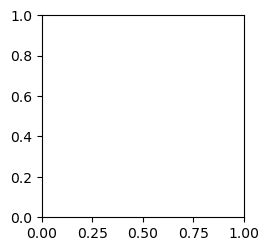

In [8]:
img = io.imread(files[2])
print(img.shape)

flow_threshold = 0.4
cellprob_threshold = 0.0
tile_norm_blocksize = 0

masks, flows, styles = model.eval(img, batch_size=32, 
                                  flow_threshold=flow_threshold, 
                                  cellprob_threshold=cellprob_threshold, 
                                  diameter=100,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0])
plt.tight_layout()
plt.show()